# Minority rule in Stargaze

In [22]:
import json
from typing import List
import requests
from funcy import compose
import pandas as pd
from jupyterthemes import jtplot

Get the state of all validators.

In [23]:
def voting_powers (validators: List) -> List[int]:
    tokens = [int(v['voting_power']) for v in validators]
    return tokens

assert(len(voting_powers(validators(stargaze_rpc)))>1)

In [24]:
def values_to_marketshares (values: List[int]) -> List[float]:
    '''
    Takes value of each firm and turns it into a proportion, i.e., 
    their share of the total market.
    '''
    total = sum(values)
    return [v / total for v in values ]

assert(values_to_marketshares([10, 10, 30]) == [0.2, 0.2, 0.6])

Get the delegation associated with each validator.

In [29]:
def percentage_who_could_pass(marketshares, majority=0.5):
    powers = list(sums(marketshares))
    for i, power in enumerate(powers):
        if power > majority:
            return i / len(powers)
    return

percentage_who_could_pass(marketshares)

0.23333333333333334

In [31]:
def validators (rpc):
    return requests.get(f'{rpc}/validators').json()['result']['validators']

stargaze_rpc = 'http://173.255.240.182:26657'
minority_rule = compose(percentage_who_could_pass, values_to_marketshares, voting_powers, validators)
minority_rule(stargaze_rpc)

0.23333333333333334

## Compare to other networks

In [35]:
from time import time
# oasis
def minority_smartstake (url):
    validators = requests.get(url).json()['data']
    values = [v['totalShares'] for v in validators]
    return percentage_who_could_pass(values_to_marketshares(values))

minority_smartstake(f'https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token={int(time())}&app=OASIS')

0.16216216216216217

In [38]:
hhis = {
    'Stargaze': minority_rule(stargaze_rpc),
    'Juno': minority_rule('https://rpc-juno.itastakers.com'),
    'Cosmos Hub': minority_rule('https://cosmoshub.validator.network:443'),
    'Osmosis': minority_rule('https://rpc-osmosis.keplr.app'),
    'Akash': minority_rule('https://rpc-akash.keplr.app'),
    'Regen':  minority_rule('https://rpc-regen.keplr.app'),
    'Sentinel': minority_rule('https://rpc-sentinel.keplr.app'),
    'Oasis': minority_smartstake(f'https://oprod.smartstakeapi.com/listData?type=oasisPools&selectedInd=True&key=2mwTEDr9zXJH323M&token={int(time())}&app=OASIS'),
    'Terra': minority_smartstake(f'https://ucyy8jicu2.execute-api.us-east-1.amazonaws.com/prod/listData?type=listPools&status=Bonded&key=2mwTEDr9zXJH323M&token={int(time())}&app=TERRA')
}

Text(0, 0.5, '% of validators that could pass a proposal')

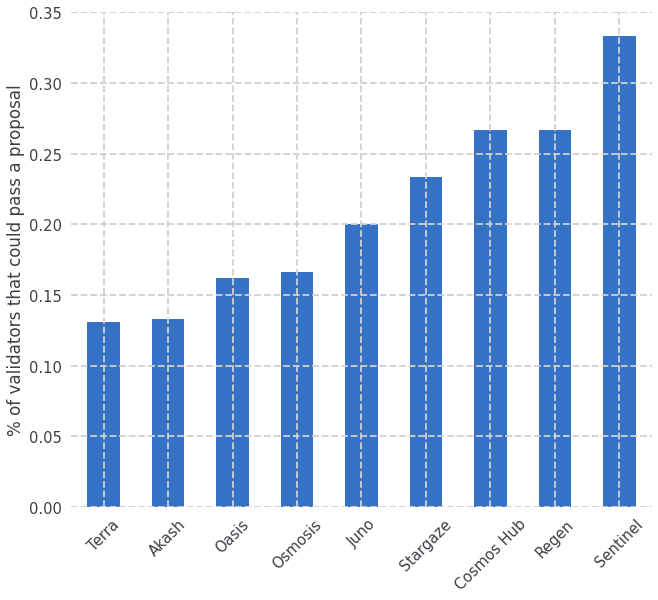

In [41]:
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

ax = pd.Series(hhis).sort_values().plot.bar(rot=45)
ax.set_ylabel('% of validators that could pass a proposal')

In [42]:
hhis['Terra']

0.13076923076923078